In [6]:
import numpy as np
import json
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from FastMap import FastMap, show_cluster, distance
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize

In [2]:
data = np.load('vec_data.npz')

In [3]:
vectors = []
labels = []
names = []

for idx, label in enumerate(data):
    univ = data[label][()]
    for name in univ:
        vectors.append(univ[name])
        labels.append(idx)
        names.append(name)
        
vectors = np.asarray(vectors)
vectors = normalize(vectors)

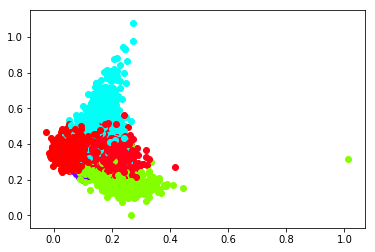

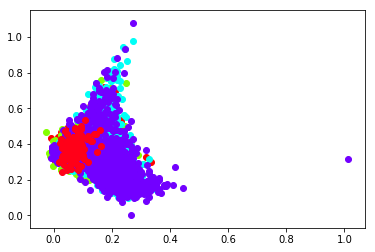

In [5]:
d = 2
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(vectors)
pca = PCA(n_components=d)
pca.fit(vectors.T)
dist = euclidean_distances(vectors, vectors)
X2, PA2 = FastMap(d, dist, vectors.shape[0])
show_cluster(X2, kmeans.labels_, d)
show_cluster(X2, labels, d)

In [7]:
count = np.zeros((5, k))

cluster = {}
for i in range(k):
    cluster[i] = []

for (idx, (univ, clst)) in enumerate(zip(labels, kmeans.labels_)):
    count[univ][clst] += 1
    cluster[clst].append(names[idx])

with open('cluster.json', 'w') as fp:
    json.dump(cluster, fp)

print(count)

[[ 132.    9.  135.    6.   17.]
 [ 189.   41.   97.  166.   73.]
 [  75.  152.  323.   93.  165.]
 [ 112.  401.  213.   12.  501.]
 [ 107.    0.    2.    0.    0.]]
